In [23]:
#Created by: Remy Welch
#Date: Jan 24, 2020
#This module is data preparation for a final portfolio project for the Udacity Machine Learning Nanodegree Course
#Overview: The dataset is publically available census data from 1995. The goal will be to predict the marital status (never married, married) of an individual using XGBoost

#import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score


In [24]:
#Import data. Data has already been split into train/test
train_set = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header = None)
test_set = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test',
                      skiprows = 1, header = None) # Make sure to skip a row for the test set

In [25]:
#Check first few rows for any error
#train_set.head()

In [26]:
#add Header Labels
col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
             'wage_class']
train_set.columns = col_labels
test_set.columns = col_labels

In [27]:
# Replace fields with the ' ?' with NA, then drop them from the dataset
train_nomissing = train_set.replace(' ?', np.nan).dropna()
test_nomissing = test_set.replace(' ?', np.nan).dropna()

In [28]:
#Fix the data issue in the test dataset where the wage_class field has a period at the end
test_nomissing['wage_class'] = test_nomissing.wage_class.replace({' <=50K.': ' <=50K', ' >50K.':' >50K'})


In [29]:
#We need to change the categorical columns into numerical/ordinal inputs for the xgboost model.
#Combine the test and train datasets
combined_mar = pd.concat([train_nomissing, test_nomissing], axis = 0) # Stacks them vertically


In [30]:
#create target variable for marital status, and drop original column
combined_mar['marital_bin'] = combined_mar['marital_status'].apply(lambda x: 0 if x == ' Never-married' else 1)
combined_mar = combined_mar.drop(columns='marital_status')


In [35]:
combined_mar.head()

,age,workclass,fnlwgt,education,education_num,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class,marital_bin
0,39,5,77516,9,13,0,1,4,1,2174,0,40,38,0,0
1,50,4,83311,9,13,3,0,4,1,0,0,13,38,0,1
2,38,2,215646,11,9,5,1,4,1,0,0,40,38,0,1
3,53,2,234721,1,7,5,0,2,1,0,0,40,38,0,1
4,28,2,338409,9,13,9,5,2,0,0,0,40,4,0,1


In [31]:
#Loop through columns in the combined dataframe and replace strings with an integer
for feature in combined_mar.columns:
    if combined_mar[feature].dtype == 'object': 
        combined_mar[feature] = pd.Categorical(combined_mar[feature]).codes # Replace strings with an integer

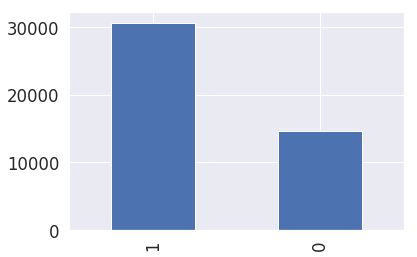

In [45]:
#histrogram of target
combined_mar['marital_bin'].value_counts().plot(kind='bar')

In [11]:
#Split up the dataset back into train and test sets
final_train = combined_mar[:train_nomissing.shape[0]] # Up to the last initial training set row
final_test = combined_mar[train_nomissing.shape[0]:] # Past the last initial training set row

In [12]:
#assign the target variable - marital status
y_train = final_train.pop('marital_bin')
y_test = final_test.pop('marital_bin')

In [13]:
#Now we will make XGboost more efficient using a DMatrix and early stopping rounds
#Create Dmatrix
xgdmat = xgb.DMatrix(final_train, y_train) 

/usr/local/lib/python3.5/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.5/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [14]:
#Do a Grid Search to determine the optimal max depth and min_child_weight. These are parameters which can be tuned to increase the accuracy of the XGboost tree 
cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5]}
ind_params = {'learning_rate': 0.1, 'n_estimators': 1000, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic'}
optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'accuracy', cv = 5, n_jobs = -1) 
# Optimize for accuracy since that is the metric used in the Adult Data Set notation

In [15]:
#preform the grid search with 5-fold cross validation and see which parameters create the most accurate model
optimized_GBM.fit(final_train, y_train)

/usr/local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=None,
       subsample=0.8, verbosity=1),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [22]:
GridSearchCV(cv=5, error_score='raise',
       estimator=xgb.XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'min_child_weight': [1, 3, 5], 'max_depth': [3, 5, 7]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=-1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8, verbosity=1),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [23]:
optimized_GBM.grid_scores_


[mean: 0.89324, std: 0.00390, params: {'max_depth': 3, 'min_child_weight': 1},
 mean: 0.89195, std: 0.00387, params: {'max_depth': 3, 'min_child_weight': 3},
 mean: 0.89245, std: 0.00414, params: {'max_depth': 3, 'min_child_weight': 5},
 mean: 0.88847, std: 0.00412, params: {'max_depth': 5, 'min_child_weight': 1},
 mean: 0.88867, std: 0.00437, params: {'max_depth': 5, 'min_child_weight': 3},
 mean: 0.88917, std: 0.00421, params: {'max_depth': 5, 'min_child_weight': 5},
 mean: 0.88505, std: 0.00459, params: {'max_depth': 7, 'min_child_weight': 1},
 mean: 0.88572, std: 0.00449, params: {'max_depth': 7, 'min_child_weight': 3},
 mean: 0.88446, std: 0.00558, params: {'max_depth': 7, 'min_child_weight': 5}]

In [24]:
#Specify the best parameters from the last round of experimentation
our_params = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':3, 'min_child_weight':1} 
# Grid Search CV optimized settings

cv_xgb = xgb.cv(params = our_params, dtrain = xgdmat, num_boost_round = 3000, nfold = 5,
                metrics = ['error'], 
                early_stopping_rounds = 100) # Choose a high number so we can look for early stopping that minimizes error


In [25]:
#Look at results
cv_xgb.tail(5)

,test-error-mean,test-error-std,train-error-mean,train-error-std
172,0.104104,0.003695,0.100607,0.000715
173,0.104005,0.003728,0.100524,0.000749
174,0.104038,0.003545,0.100466,0.000736
175,0.103906,0.003443,0.100358,0.000893
176,0.103806,0.003491,0.100383,0.000899


In [26]:
#Assign the final parameters that have been chosen via a Grid Search, optimizing for accuracy
final_params = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':3, 'min_child_weight':1} 

#Train the XGBoost model, using early stopping at 175 rounds. 
#The optimal stopping rounds was determined by creating a Dmatrix and running another CV, this time setting an aggresive number of max rounds at 3000
final_gb = xgb.train(final_params, xgdmat, num_boost_round = 175)

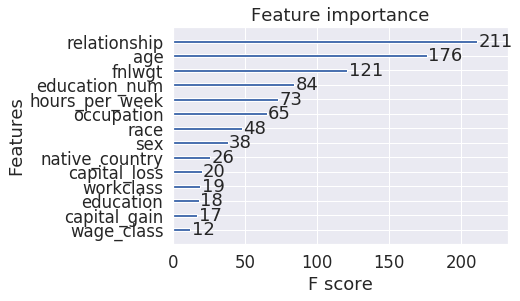

In [27]:
#Look at Feature importance
%matplotlib inline
import seaborn as sns
sns.set(font_scale = 1.5)
xgb.plot_importance(final_gb)

In [36]:
#Ah, of course, relationship is the best feature. Need to remove that
combined_mar = combined_mar.drop(axis=1,columns=['relationship'])


In [37]:
#Split up the dataset back into train and test sets
final_train = combined_mar[:train_nomissing.shape[0]] # Up to the last initial training set row
final_test = combined_mar[train_nomissing.shape[0]:] # Past the last initial training set row
#assign the target variable - marital status
y_train = final_train.pop('marital_bin')
y_test = final_test.pop('marital_bin')
#Now we will make XGboost more efficient using a DMatrix and early stopping rounds
#Create Dmatrix
xgdmat = xgb.DMatrix(final_train, y_train) 
#Do a Grid Search to determine the optimal max depth and min_child_weight. These are parameters which can be tuned to increase the accuracy of the XGboost tree 
cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5]}
ind_params = {'learning_rate': 0.1, 'n_estimators': 1000, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic'}
optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'accuracy', cv = 5, n_jobs = -1) 
# Optimize for accuracy since that is the metric used in the Adult Data Set notation
#preform the grid search with 5-fold cross validation and see which parameters create the most accurate model
optimized_GBM.fit(final_train, y_train)
GridSearchCV(cv=5, error_score='raise',
       estimator=xgb.XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'min_child_weight': [1, 3, 5], 'max_depth': [3, 5, 7]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)
optimized_GBM.grid_scores_

/usr/local/lib/python3.5/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.5/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/site-packages/sklearn/preprocessing/l

[mean: 0.83420, std: 0.00574, params: {'max_depth': 3, 'min_child_weight': 1},
 mean: 0.83423, std: 0.00618, params: {'max_depth': 3, 'min_child_weight': 3},
 mean: 0.83496, std: 0.00632, params: {'max_depth': 3, 'min_child_weight': 5},
 mean: 0.82816, std: 0.00413, params: {'max_depth': 5, 'min_child_weight': 1},
 mean: 0.82856, std: 0.00445, params: {'max_depth': 5, 'min_child_weight': 3},
 mean: 0.82760, std: 0.00525, params: {'max_depth': 5, 'min_child_weight': 5},
 mean: 0.82130, std: 0.00493, params: {'max_depth': 7, 'min_child_weight': 1},
 mean: 0.82362, std: 0.00611, params: {'max_depth': 7, 'min_child_weight': 3},
 mean: 0.82180, std: 0.00595, params: {'max_depth': 7, 'min_child_weight': 5}]

In [ ]:
#Specify the best parameters from the last round of experimentation
our_params = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':3, 'min_child_weight':1} 
# Grid Search CV optimized settings

cv_xgb = xgb.cv(params = our_params, dtrain = xgdmat, num_boost_round = 3000, nfold = 5,
                metrics = ['error'], 
                early_stopping_rounds = 100) # Choose a high number so we can look for early stopping that minimizes error

#Look at results
cv_xgb.tail(5)

,test-error-mean,test-error-std,train-error-mean,train-error-std
296,0.163981,0.003411,0.156099,0.000667
297,0.164047,0.003334,0.156099,0.000609
298,0.164047,0.003365,0.156057,0.000574
299,0.164047,0.003353,0.155999,0.000510
300,0.163915,0.003247,0.156008,0.000487


In [ ]:
#Assign the final parameters that have been chosen via a Grid Search, optimizing for accuracy
final_params = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':3, 'min_child_weight':1} 

#Train the XGBoost model, using early stopping at 175 rounds. 
#The optimal stopping rounds was determined by creating a Dmatrix and running another CV, this time setting an aggresive number of max rounds at 3000
final_gb = xgb.train(final_params, xgdmat, num_boost_round = 175)

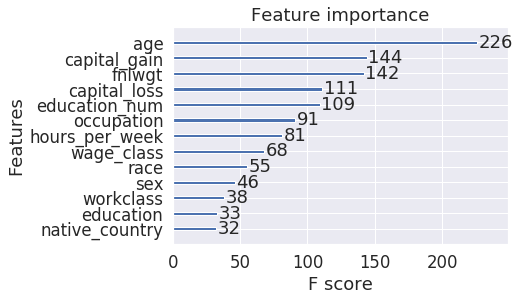

In [40]:
#Look at Feature importance with relationship removed
%matplotlib inline
import seaborn as sns
sns.set(font_scale = 1.5)
xgb.plot_importance(final_gb)

In [41]:
#now test the model on our test data to see if it holds up. First create a Dmatrix for the test set
testdmat = xgb.DMatrix(final_test)
#Get the accuracy using sklearn's metrics
y_pred = final_gb.predict(testdmat) 

In [42]:
#Round up/down to 0 (below 5k) or 1 (above 50k)
threshold = 0.5
y_pred[y_pred > threshold] = 1
y_pred[y_pred <= threshold] = 0
y_pred

array([0., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [43]:
#Get final accuracy
accuracy_score(y_pred, y_test), 1-accuracy_score(y_pred, y_test)

(0.8335325365205843, 0.16646746347941566)